<a href="https://colab.research.google.com/github/AImSecure/Laboratory1/blob/main/lab/notebooks/Lab1_FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory 1 — Feed Forward Neural Networks

This notebook follows the lab brief in `resources/Lab1_FFNN.txt` and is organized into tasks:
- Task 1: Data preprocessing (cleaning, splitting, outliers, normalization)
- Task 2: Shallow NN (1 layer), train sizes {32, 64, 128}, metrics and analysis; then ReLU change
- Task 3: Impact of specific features (Destination Port), bias test and port removal
- Task 4: Loss function impact (weighted CrossEntropy)
- Task 5: Deep NN, batch size, optimizer comparisons
- Task 6: Overfitting and regularization (dropout, batchnorm, weight decay)

## Setup

In [102]:
# --- Check Python & pip versions ---
!python --version
!pip install --upgrade pip

Python 3.12.12


In [103]:

# --- Install required libraries ---
!pip install torch
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install tqdm

In [171]:
# --- Import libraries ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm import tqdm

### Colab Pro

In [172]:
# --- Check GPU availability ---
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [173]:
# --- Check RAM availability ---
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Paths setup


In [174]:
# --- Mount Google Drive (for Google Colab users) ---
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [175]:
# --- Define Paths ---
group = 'AImSecure'
laboratory = 'Laboratory1'

base_path = '/content/drive/MyDrive/'
project_path = base_path + f'Projects/{group}/{laboratory}/'
data_path = project_path + 'data/'
results_path = project_path + 'results/'

# --- Ensure directories exist ---
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/
Data path: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/data/
Results path: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/


In [176]:
# --- Set visual style ---
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

def save_plot(fig: plt.Figure, filename: str, path: str = "./plots/", fmt: str = "png", dpi: int = 300) -> None:
    """
    Save a Matplotlib figure in a specific to a specified directory.

    Args:
        fig (plt.Figure): Matplotlib figure object to save.
        filename (str): Name of the file to save (e.g., 'plot.png').
        path (str, optional): Directory path to save the figure. Defaults to './plots/'.
        fmt (str, optional): File format for the saved figure. Defaults to 'png'.
        dpi (int, optional): Dots per inch for the saved figure. Defaults to 300.

    Returns:
        None
    """
    # Ensure the directory exists
    os.makedirs(path, exist_ok=True)
    save_path = os.path.join(path, f"{filename}.{fmt}")

    # Save the figure
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=dpi, format=fmt)
    # plt.close(fig) # Removed to display plots in notebook

    print(f"Saved plot: {save_path}")

## Task 1 — Data preprocessing
What we will do:
- Load CSV from `lab/data/dataset_lab_1.csv`
- Inspect basic info, class distribution, and feature ranges
- Remove NaN and duplicate rows; report counts before/after
- Split into train/val/test with stratify (60/20/20, fixed SEED)
- Inspect outliers on train/val (e.g., boxplots, z-scores) and choose normalization
- Fit scaler on train only; transform val/test; persist scaler if needed

In [177]:
# --- Load dataset and perform initial inspection ---

# Set random seed for reproducibility
np.random.seed(42)

# Create directory for plots
save_dir = results_path + 'images/' + 'task1_plots/'
os.makedirs(save_dir, exist_ok=True)

# Load Dataset
file_path = data_path + 'dataset_lab_1.csv'
df = pd.read_csv(file_path)

print("Shape (raw):", df.shape)
print("Columns:", list(df.columns))
print(df.head(3))

# Basic info
print("\nLabel distribution (raw):")
print(df['Label'].value_counts(dropna=False))

Shape (raw): (31507, 17)
Columns: ['Flow Duration', 'Flow IAT Mean', 'Fwd PSH Flags', 'Bwd Packet Length Mean', 'Bwd Packet Length Max', 'Flow Bytes/s', 'Down/Up Ratio', 'SYN Flag Count', 'Fwd Packet Length Mean', 'Fwd IAT Std', 'Packet Length Mean', 'Fwd Packet Length Max', 'Subflow Fwd Packets', 'Flow Packets/s', 'Total Fwd Packets', 'Destination Port', 'Label']
   Flow Duration  Flow IAT Mean  Fwd PSH Flags  Bwd Packet Length Mean  \
0         303376        30337.6              0                   749.4   
1            117          117.0              0                     0.0   
2            142          142.0              0                     0.0   

   Bwd Packet Length Max  Flow Bytes/s  Down/Up Ratio  SYN Flag Count  \
0                   1448     12743.263              0               0   
1                      0         0.000              1               0   
2                      0     84507.040              0               0   

   Fwd Packet Length Mean  Fwd IAT Std  Pac

In [178]:
def plot_class_distribution(
    df,
    label_col='Label',
    save_path='./plots/',
    fig_size=(8, 5),
    color='Set2'
):
    """
    Plot the number of samples for each class.

    Args:
        df (pd.DataFrame): The input DataFrame.
        label_col (str): The name of the label column. Defaults to 'Label'.
        save_path (str): The directory to save the plot. Defaults to './plots/'.
        fig_size (tuple): Size of the figure. Defaults to (8, 5).
        color (str): Seaborn color.
    """
    os.makedirs(save_path, exist_ok=True)

    # Create a figure and axes for the plot
    fig, ax = plt.subplots(figsize=fig_size)

    # Create a countplot showing the distribution of classes
    sns.countplot(x=label_col, data=df, order=df[label_col].value_counts().index, ax=ax, color='skyblue')

    # Set the title and labels for the plot
    ax.set_title("Class Distribution")
    ax.set_xlabel("Traffic Type")
    ax.set_ylabel("Count")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=30)

    # Annotate bars with counts
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    # Save the plot to the specified path
    save_plot(fig, "class_distribution", save_path)

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/class_distribution.png


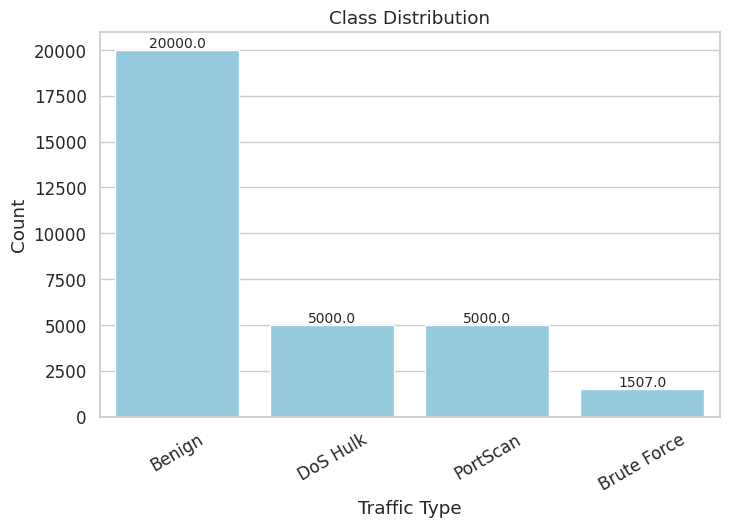

In [179]:
# --- Visualize raw data characteristics and distributions ---

# Plot class distribution to understand data balance
plot_class_distribution(df, save_path=save_dir)

# TODO: check for other useful plots

### Removing NaN and duplicates

In [180]:
# --- Remove NaN and duplicates ---

raw_n = len(df)
df = df.dropna()
df = df.drop_duplicates()
clean_n = len(df)

print(f"Removed {raw_n-clean_n} rows (NaN+dupes). New shape: {df.shape}")

Removed 2114 rows (NaN+dupes). New shape: (29393, 17)


In [181]:
# --- Handle infinite values ---

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for and report the number of infinite values (now NaNs)
inf_counts = df.isnull().sum()
print("\nNumber of infinite values (replaced with NaN) per column:")
print(inf_counts[inf_counts > 0])

# Drop rows with NaN values (including those that were originally infinite)
initial_rows = len(df)
df.dropna(inplace=True)
rows_after_inf_nan_drop = len(df)

print(f"\nRemoved {initial_rows - rows_after_inf_nan_drop} rows containing infinite or NaN values. New shape: {df.shape}")


Number of infinite values (replaced with NaN) per column:
Flow Bytes/s      7
Flow Packets/s    7
dtype: int64

Removed 7 rows containing infinite or NaN values. New shape: (29386, 17)


In [182]:
print("\nLabel distribution (after NaN and duplicates removal):")
print(df['Label'].value_counts())


Label distribution (after NaN and duplicates removal):
Label
Benign         19242
PortScan        4849
DoS Hulk        3868
Brute Force     1427
Name: count, dtype: int64


In [183]:
# Encode labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

df.head()

,Flow Duration,Flow IAT Mean,Fwd PSH Flags,Bwd Packet Length Mean,Bwd Packet Length Max,Flow Bytes/s,Down/Up Ratio,SYN Flag Count,Fwd Packet Length Mean,Fwd IAT Std,Packet Length Mean,Fwd Packet Length Max,Subflow Fwd Packets,Flow Packets/s,Total Fwd Packets,Destination Port,Label
0,303376,30337.600000,0,749.4,1448,12743.263,0,0,19.833334,98776.15,322.16666,119,6,36.258636,6,443,0
1,117,117.000000,0,0.0,0,0.000,1,0,0.000000,0.00,0.00000,0,1,17094.018000,1,52631,0
2,142,142.000000,0,0.0,0,84507.040,0,0,6.000000,0.00,6.00000,6,2,14084.507000,2,80,0
3,191,63.666668,0,52.0,52,921465.940,1,0,36.000000,0.00,42.40000,36,2,20942.408000,2,53,0
4,4,4.000000,0,0.0,0,3000000.000,0,0,6.000000,0.00,6.00000,6,2,500000.000000,2,49467,0


In [184]:
# Checking null values
print(df.isnull().sum())

Flow Duration             0
Flow IAT Mean             0
Fwd PSH Flags             0
Bwd Packet Length Mean    0
Bwd Packet Length Max     0
Flow Bytes/s              0
Down/Up Ratio             0
SYN Flag Count            0
Fwd Packet Length Mean    0
Fwd IAT Std               0
Packet Length Mean        0
Fwd Packet Length Max     0
Subflow Fwd Packets       0
Flow Packets/s            0
Total Fwd Packets         0
Destination Port          0
Label                     0
dtype: int64


In [217]:
# check for the infinite values
print(df.isin([np.inf, -np.inf]).sum())

Flow Duration             0
Flow IAT Mean             0
Fwd PSH Flags             0
Bwd Packet Length Mean    0
Bwd Packet Length Max     0
Flow Bytes/s              0
Down/Up Ratio             0
SYN Flag Count            0
Fwd Packet Length Mean    0
Fwd IAT Std               0
Packet Length Mean        0
Fwd Packet Length Max     0
Subflow Fwd Packets       0
Flow Packets/s            0
Total Fwd Packets         0
Destination Port          0
Label                     0
dtype: int64


In [218]:
df

,Flow Duration,Flow IAT Mean,Fwd PSH Flags,Bwd Packet Length Mean,Bwd Packet Length Max,Flow Bytes/s,Down/Up Ratio,SYN Flag Count,Fwd Packet Length Mean,Fwd IAT Std,Packet Length Mean,Fwd Packet Length Max,Subflow Fwd Packets,Flow Packets/s,Total Fwd Packets,Destination Port,Label
0,303376,3.033760e+04,0,749.4,1448,12743.263,0,0,19.833334,98776.15,322.16666,119,6,36.258636,6,443,0
1,117,1.170000e+02,0,0.0,0,0.000,1,0,0.000000,0.00,0.00000,0,1,17094.018000,1,52631,0
2,142,1.420000e+02,0,0.0,0,84507.040,0,0,6.000000,0.00,6.00000,6,2,14084.507000,2,80,0
3,191,6.366667e+01,0,52.0,52,921465.940,1,0,36.000000,0.00,42.40000,36,2,20942.408000,2,53,0
4,4,4.000000e+00,0,0.0,0,3000000.000,0,0,6.000000,0.00,6.00000,6,2,500000.000000,2,49467,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31502,5710955,1.903652e+06,0,0.0,0,0.000,0,0,0.000000,4037277.80,0.00000,0,3,0.700408,3,80,1
31503,5862561,1.954187e+06,0,0.0,0,0.000,0,0,0.000000,4144374.80,0.00000,0,3,0.682296,3,80,1
31504,5854872,1.951624e+06,0,0.0,0,0.000,0,0,0.000000,4139029.80,0.00000,0,3,0.683192,3,80,1
31505,5555547,1.851849e+06,0,0.0,0,0.000,0,0,0.000000,3927356.50,0.00000,0,3,0.720001,3,80,1


### Split data

In [219]:
# --- Split data ---

# Split features/target
label_col = 'Label'
feature_cols = [c for c in df.columns if c != label_col]
X = df[feature_cols].values
y = df[label_col].values

# We use a stratified approach due to the class imbalance

# Train/val/test split 60/20/20 with stratify
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)
print("Splits:", X_train.shape, X_val.shape, X_test.shape)
print("Train label counts:\n", np.unique(y_train, return_counts=True))
print("Val label counts:\n", np.unique(y_val, return_counts=True))
print("Test label counts:\n", np.unique(y_test, return_counts=True))

Splits: (17631, 16) (5877, 16) (5878, 16)
Train label counts:
 (array([0, 1, 2, 3]), array([11545,   856,  2321,  2909]))
Val label counts:
 (array([0, 1, 2, 3]), array([3848,  286,  773,  970]))
Test label counts:
 (array([0, 1, 2, 3]), array([3849,  285,  774,  970]))


### Normalize data and handle outliers

In [220]:
# ------------------------------------------------------------
# STEP 2 — Outlier detection (Z-score and IQR)
# ------------------------------------------------------------
# Convert X_train to DataFrame to use select_dtypes
X_train_df = pd.DataFrame(X_train, columns=feature_cols)

num_cols = X_train_df.select_dtypes(include=[np.number]).columns.tolist()
print(num_cols)

# Z-score method
zs = ((X_train_df[num_cols] - X_train_df[num_cols].mean()) / X_train_df[num_cols].std(ddof=0)).abs()
outlier_counts_z = (zs > 3).sum().sort_values(ascending=False)
print("\n[Z-SCORE OUTLIERS] features:")
print(outlier_counts_z)

# IQR method
Q1 = X_train_df[num_cols].quantile(0.25)
Q3 = X_train_df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((X_train_df[num_cols] < (Q1 - 1.5 * IQR)) | (X_train_df[num_cols] > (Q3 + 1.5 * IQR))).sum()
outlier_counts_iqr = outliers_iqr.sort_values(ascending=False)
print("\n[IQR OUTLIERS] features:")
print(outlier_counts_iqr)

['Flow Duration', 'Flow IAT Mean', 'Fwd PSH Flags', 'Bwd Packet Length Mean', 'Bwd Packet Length Max', 'Flow Bytes/s', 'Down/Up Ratio', 'SYN Flag Count', 'Fwd Packet Length Mean', 'Fwd IAT Std', 'Packet Length Mean', 'Fwd Packet Length Max', 'Subflow Fwd Packets', 'Flow Packets/s', 'Total Fwd Packets', 'Destination Port']

[Z-SCORE OUTLIERS] features:
Fwd PSH Flags             708
SYN Flag Count            708
Fwd IAT Std               567
Bwd Packet Length Max     523
Flow Packets/s            522
Bwd Packet Length Mean    340
Packet Length Mean        272
Destination Port          247
Fwd Packet Length Max     238
Flow IAT Mean             207
Fwd Packet Length Mean    157
Subflow Fwd Packets        88
Total Fwd Packets          88
Down/Up Ratio              48
Flow Bytes/s               37
Flow Duration               0
dtype: int64

[IQR OUTLIERS] features:
Bwd Packet Length Max     3951
Destination Port          3879
Flow Duration             3443
Bwd Packet Length Mean    3180
Pac

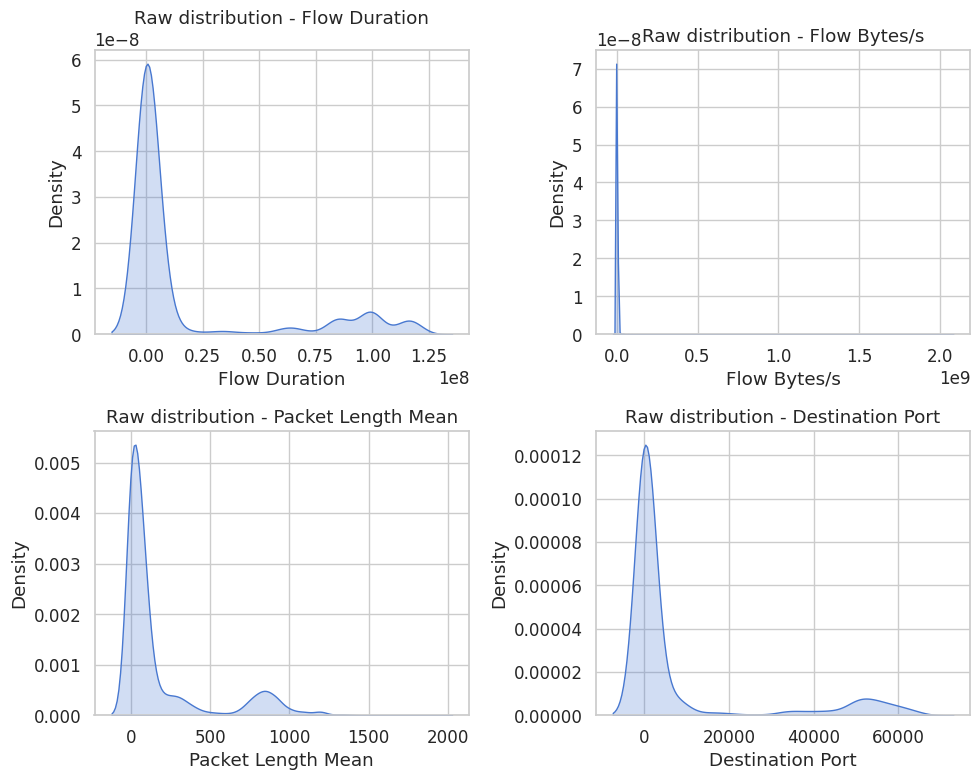

In [221]:
# ------------------------------------------------------------
# STEP 3 — Visualize raw distributions for selected features
# ------------------------------------------------------------
selected_features = ['Flow Duration', 'Flow Bytes/s', 'Packet Length Mean', 'Destination Port'] # TODO: change

# Convert X_train to DataFrame for easier plotting with column names
X_train_df = pd.DataFrame(X_train, columns=feature_cols)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, col in enumerate(selected_features):
    sns.kdeplot(X_train_df[col], ax=axes[i//2, i%2], fill=True)
    axes[i//2, i%2].set_title(f"Raw distribution - {col}")
plt.tight_layout()
plt.show()

In [222]:
# Standardize the features (StandardScaler)
scaler1 = StandardScaler()
X_train_std = scaler1.fit_transform(X_train)
X_val_std = scaler1.transform(X_val)
X_test_std = scaler1.transform(X_test)

# Standardize the features (RobustScaler)
scaler2 = RobustScaler()
X_train_rob = scaler2.fit_transform(X_train)
X_val_rob = scaler2.transform(X_val)
X_test_rob = scaler2.transform(X_test)

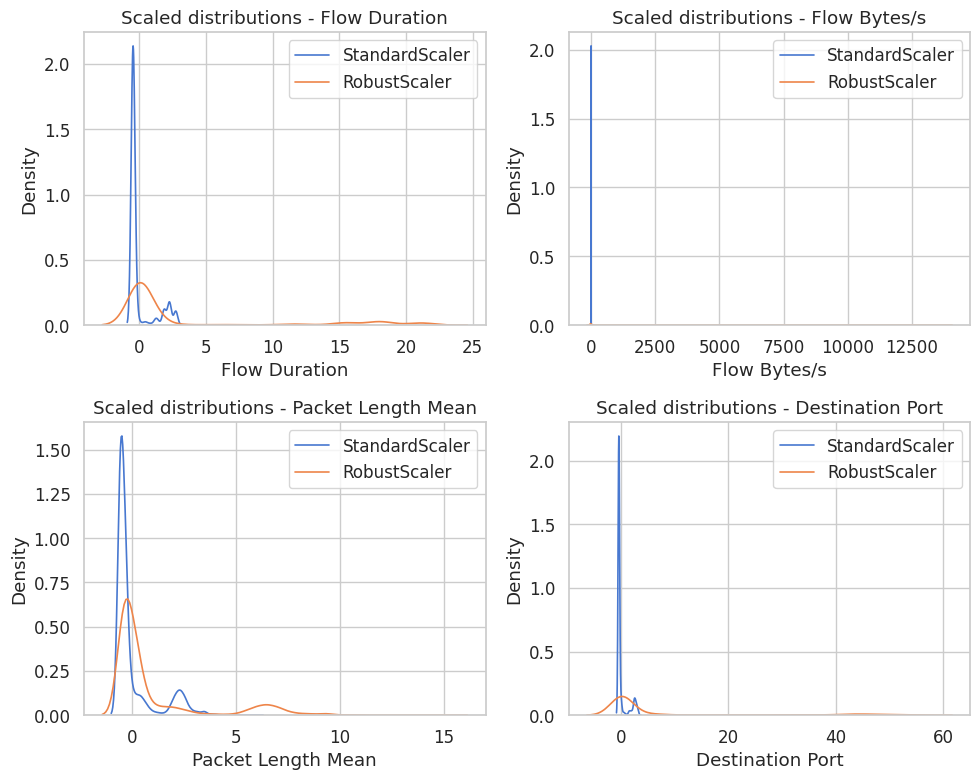

In [224]:
# ------------------------------------------------------------
# STEP 6 — Visual comparison of Standard vs Robust scaling
# ------------------------------------------------------------
# Convert scaled arrays back to DataFrames for easier plotting with column names
X_train_std_df = pd.DataFrame(X_train_std, columns=feature_cols)
X_train_rob_df = pd.DataFrame(X_train_rob, columns=feature_cols)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, col in enumerate(selected_features):
    sns.kdeplot(X_train_std_df[col], ax=axes[i//2, i%2], label="StandardScaler", lw=1.2)
    sns.kdeplot(X_train_rob_df[col], ax=axes[i//2, i%2], label="RobustScaler", lw=1.2)
    axes[i//2, i%2].set_title(f"Scaled distributions - {col}")
    axes[i//2, i%2].legend()
plt.tight_layout()
plt.show()

In [225]:
# ------------------------------------------------------------
# STEP 7 — Compare scaling statistics numerically
# ------------------------------------------------------------
stats_std = X_train_std_df.describe().T[['mean', 'std']].rename(columns={'mean': 'mean_std', 'std': 'std_std'})
stats_rob = X_train_rob_df.describe().T[['mean', 'std']].rename(columns={'mean': 'mean_rob', 'std': 'std_rob'})
scaling_comparison = stats_std.join(stats_rob)
print("\nScaling comparison (continuous features, first 10 rows):")
print(scaling_comparison.head(10))


Scaling comparison (continuous features, first 10 rows):
                            mean_std   std_std   mean_rob     std_rob
Flow Duration          -8.060152e-19  1.000028   3.209521    6.578692
Flow IAT Mean           4.674888e-16  1.000028   1.655390    4.604932
Fwd PSH Flags           1.531429e-17  1.000028   0.040157    0.196332
Bwd Packet Length Mean -7.249100e-15  1.000028   1.366380    3.176369
Bwd Packet Length Max   2.115790e-17  1.000028   2.137739    4.824989
Flow Bytes/s            7.898949e-17  1.000028  10.549447  192.030725
Down/Up Ratio           6.488423e-17  1.000028  -0.333503    0.523037
SYN Flag Count          1.531429e-17  1.000028   0.040157    0.196332
Fwd Packet Length Mean  1.020818e-15  1.000028   0.251230    2.318150
Fwd IAT Std            -2.909715e-16  1.000028   2.570055    6.266235


## Task 2 — Shallow Neural Network (1 layer)
We will:
- Define a single-hidden-layer FFNN with hidden sizes h in {32, 64, 128}
- Use Linear activation as requested (i.e., no nonlinearity) for the first run
- Train with AdamW, lr=5e-4, batch=64, CE loss, up to 100 epochs with early stopping
- Plot train/val losses, select best by lowest val loss, report validation classification
- Evaluate best on test and compare to validation
- Then change activation to ReLU for the best width and retrain; discuss change

In [235]:
# -------------------------------------------------------------
# STEP 0 — Choose dataset version
# -------------------------------------------------------------
# Options: X_train_std, X_val_std, X_test_std
#          X_train_rob, X_val_rob, X_test_rob

X_train_use = X_train_rob   # change here if you want StandardScaler
X_val_use   = X_val_rob
X_test_use  = X_test_rob

y_train_use = y_train       # labels (assume already available)
y_val_use   = y_val
y_test_use  = y_test

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_use, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_use, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_use, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_use, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val_use, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test_use, dtype=torch.long)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

In [236]:
# -------------------------------------------------------------
# STEP 1 — Define single-layer NN class
# -------------------------------------------------------------
class ShallowNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation='linear'):
        super(ShallowNN, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.activation = activation
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if self.activation == 'relu':
            x = torch.relu(self.fc(x))
        elif self.activation == 'linear':
            x = self.fc(x)
        return self.out(x)

In [237]:
# -------------------------------------------------------------
# STEP 2 — Training function with early stopping
# -------------------------------------------------------------
def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, min_delta=None, patience=None):

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_loss = np.mean(batch_losses)

        # Validation
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_batch_losses.append(loss.item())
        val_loss = np.mean(val_batch_losses)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # ---- Early Stopping ----
        if(min_delta!= None):
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print(f"Early stopping at epoch {epoch+1} (best val loss: {best_val_loss:.6f})")
                    break

        # ---- Restore best model ----
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        if (epoch+1) % 5 == 0 or epoch == 0 or epoch == epochs:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load best weights
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

In [238]:
# -------------------------------------------------------------
# STEP 3 — Train 3 models with different neurons (Linear activation)
# -------------------------------------------------------------
input_dim = X_train_use.shape[1]
output_dim = len(np.unique(y_train_use))
neurons_list = [32, 64, 128]

trained_models = {}
loss_curves = {}

# Initialize the early stopping parameters
min_delta_dict = {32: 0.0001, 64: 0.0001, 128: 0.0001}
patience_dict = {32: 20, 64: 20, 128: 20}

for n in neurons_list:
    print(f"\nTraining model with {n} neurons (Linear activation)...")
    model = ShallowNN(input_dim, n, output_dim, activation='linear')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    model, train_loss, val_loss = train_model(model, train_loader, val_loader, epochs=100, optimizer=optimizer, criterion=criterion, min_delta=min_delta_dict[n], patience=patience_dict[n])
    trained_models[n] = model
    loss_curves[n] = (train_loss, val_loss)


Training model with 32 neurons (Linear activation)...
Epoch 1/100 - Train Loss: 0.8116, Val Loss: 0.6207
Epoch 5/100 - Train Loss: 0.3967, Val Loss: 0.3660
Epoch 10/100 - Train Loss: 0.3398, Val Loss: 0.3196
Epoch 15/100 - Train Loss: 0.3268, Val Loss: 0.3111
Epoch 20/100 - Train Loss: 0.3163, Val Loss: 0.3041
Epoch 25/100 - Train Loss: 0.3191, Val Loss: 0.3027
Epoch 30/100 - Train Loss: 0.3171, Val Loss: 0.3005
Epoch 35/100 - Train Loss: 0.3100, Val Loss: 0.2952
Epoch 40/100 - Train Loss: 0.3105, Val Loss: 0.2946
Epoch 45/100 - Train Loss: 0.3110, Val Loss: 0.2953
Epoch 50/100 - Train Loss: 0.3092, Val Loss: 0.2924
Epoch 55/100 - Train Loss: 0.3068, Val Loss: 0.2983
Epoch 60/100 - Train Loss: 0.3100, Val Loss: 0.3001
Epoch 65/100 - Train Loss: 0.3026, Val Loss: 0.2930
Epoch 70/100 - Train Loss: 0.3074, Val Loss: 0.2937
Early stopping at epoch 74 (best val loss: 0.289354)

Training model with 64 neurons (Linear activation)...
Epoch 1/100 - Train Loss: 0.7991, Val Loss: 0.5683
Epoch 5/

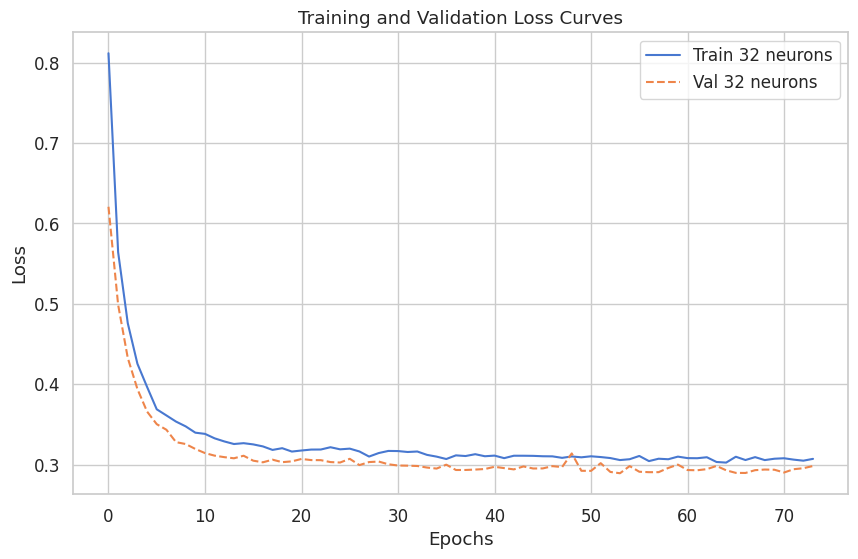

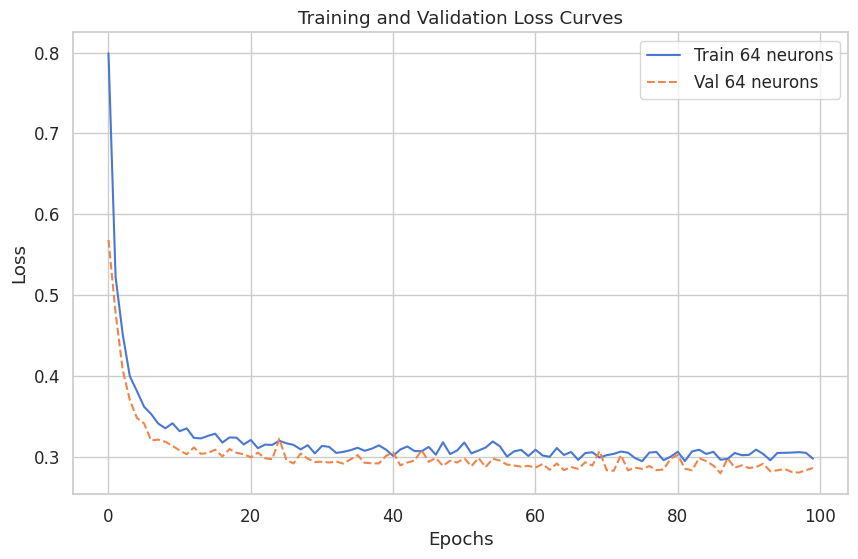

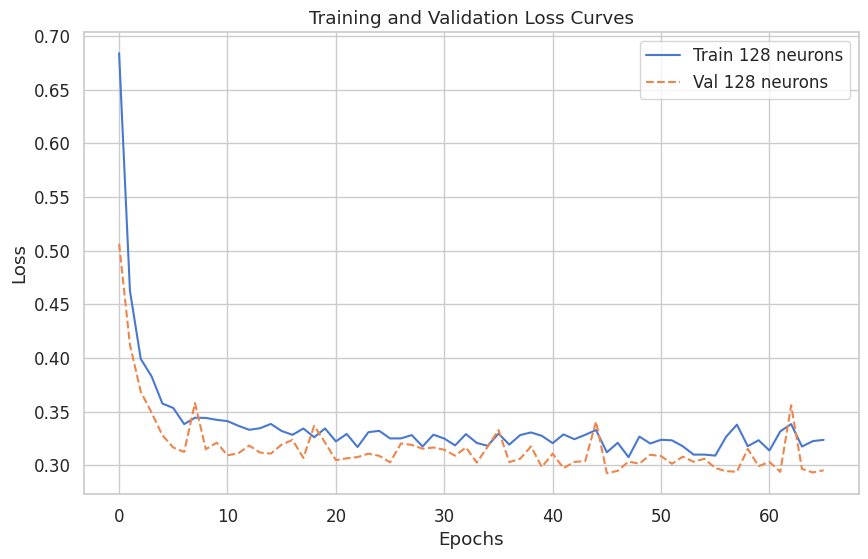

In [239]:
# -------------------------------------------------------------
# STEP 4 — Plot loss curves for all models
# -------------------------------------------------------------
for n in neurons_list:
    plt.figure(figsize=(10,6))
    train_loss, val_loss = loss_curves[n]
    plt.plot(train_loss, label=f'Train {n} neurons')
    plt.plot(val_loss, '--', label=f'Val {n} neurons')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

In [240]:
# -------------------------------------------------------------
# STEP 5 — Evaluate validation set and print classification reports
# -------------------------------------------------------------
from sklearn.metrics import classification_report

def evaluate_model(model, X_tensor, y_true):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        y_pred = torch.argmax(outputs, axis=1).numpy()
    report = classification_report(y_true, y_pred, digits=4)
    return report

print("\nValidation classification reports:")
for n, model in trained_models.items():
    print(f"\n--- Model {n} neurons ---")
    report = evaluate_model(model, X_val_tensor, y_val_use)
    print(report)


Validation classification reports:

--- Model 32 neurons ---
              precision    recall  f1-score   support

           0     0.8890    0.9532    0.9200      3848
           1     0.0000    0.0000    0.0000       286
           2     0.9855    0.8823    0.9311       773
           3     0.8276    0.8959    0.8604       970

    accuracy                         0.8880      5877
   macro avg     0.6755    0.6828    0.6779      5877
weighted avg     0.8483    0.8880    0.8668      5877


--- Model 64 neurons ---
              precision    recall  f1-score   support

           0     0.8876    0.9561    0.9206      3848
           1     0.0000    0.0000    0.0000       286
           2     0.9869    0.8797    0.9302       773
           3     0.8419    0.8948    0.8676       970

    accuracy                         0.8894      5877
   macro avg     0.6791    0.6827    0.6796      5877
weighted avg     0.8499    0.8894    0.8683      5877


--- Model 128 neurons ---
              p

In [241]:
# -------------------------------------------------------------
# STEP 6 — Select best model and evaluate on test set
# -------------------------------------------------------------
# Example: pick model with 64 neurons (replace with your best)
best_n = 32
best_model = trained_models[best_n]

print("\nTest set classification report for best model:")
report_test = evaluate_model(best_model, X_test_tensor, y_test_use)
print(report_test)


Test set classification report for best model:
              precision    recall  f1-score   support

           0     0.8888    0.9592    0.9227      3849
           1     0.0000    0.0000    0.0000       285
           2     0.9882    0.8656    0.9229       774
           3     0.8325    0.8918    0.8611       970

    accuracy                         0.8892      5878
   macro avg     0.6774    0.6791    0.6767      5878
weighted avg     0.8495    0.8892    0.8678      5878




Retraining best model (32 neurons) with ReLU activation...
Epoch 1/100 - Train Loss: 1.6149, Val Loss: 1.6110
Epoch 5/100 - Train Loss: 1.6151, Val Loss: 1.6110
Epoch 10/100 - Train Loss: 1.6149, Val Loss: 1.6110
Epoch 15/100 - Train Loss: 1.6154, Val Loss: 1.6110
Epoch 20/100 - Train Loss: 1.6154, Val Loss: 1.6110
Early stopping at epoch 21 (best val loss: 1.610986)


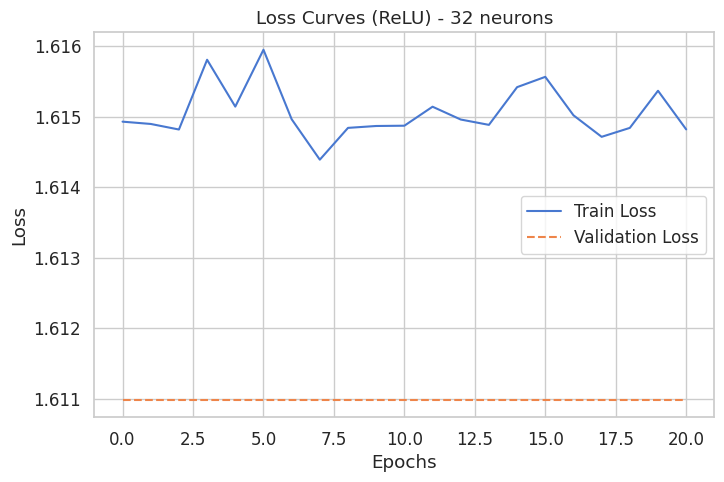


Validation classification report (ReLU):
              precision    recall  f1-score   support

           0     0.9024    0.1754    0.2937      3848
           1     0.0323    0.0490    0.0389       286
           2     0.2281    0.8266    0.3576       773
           3     0.0164    0.0320    0.0216       970

    accuracy                         0.2312      5877
   macro avg     0.2948    0.2707    0.1780      5877
weighted avg     0.6251    0.2312    0.2448      5877



In [242]:
# -------------------------------------------------------------
# STEP 7 — Retrain best model with ReLU activation
# -------------------------------------------------------------
print(f"\nRetraining best model ({best_n} neurons) with ReLU activation...")
model_relu = ShallowNN(input_dim, best_n, output_dim, activation='relu')
min_delta = 0.00001
patience = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
model_relu, train_loss_relu, val_loss_relu = train_model(model_relu, train_loader, val_loader, epochs=100, optimizer=optimizer, criterion=criterion, min_delta=min_delta, patience=patience)

# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(train_loss_relu, label='Train Loss')
plt.plot(val_loss_relu, '--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curves (ReLU) - {best_n} neurons')
plt.legend()
plt.show()

# Validation report for ReLU
print("\nValidation classification report (ReLU):")
report_val_relu = evaluate_model(model_relu, X_val_tensor, y_val_use)
print(report_val_relu)

## Task 3 — Impact of specific features (Destination Port)
Steps:
1) Modify only the test split: for rows with Label==Brute Force and Destination Port==80, change to 8080. Re-run inference with the best model and compare test metrics to validation baseline.
2) Remove the Destination Port feature entirely from the original dataset; redo preprocessing (cleaning, split, scaling); report PortScan counts before/after duplicates removal; discuss class balance.
Note: Keep a copy of the original splits to ensure fair comparisons.

In [ ]:
# 3.1: Modify Destination Port for Brute Force in Test and re-evaluate
if 'Destination Port' in feature_cols:
    # Build a modifiable DataFrame for test
    test_df = X_test.copy()
    test_df['Label'] = y_test.values
    before_counts = (test_df[(test_df['Label']=='Brute Force') & (test_df['Destination Port']==80)].shape[0])
    # Change 80 -> 8080 for Brute Force
    mask = (test_df['Label']=='Brute Force') & (test_df['Destination Port']==80)
    test_df.loc[mask, 'Destination Port'] = 8080
    after_counts = (test_df[(test_df['Label']=='Brute Force') & (test_df['Destination Port']==80)].shape[0])
    print(f"Changed Brute Force port 80 -> 8080 in test: {before_counts} rows affected, now {after_counts} with port==80")

    # Re-standardize using the SAME scaler (train fit)
    test_df_std = scaler.transform(test_df[num_cols])
    X_test_mod_t = torch.tensor(test_df_std, dtype=torch.float32)
    y_test_mod_t = torch.tensor(y_test_i, dtype=torch.long)
    test_mod_loader = DataLoader(TensorDataset(X_test_mod_t, y_test_mod_t), batch_size=BATCH_SIZE)

    # Inference with the best validation model (from Task 2)
    mod_loss, mod_preds, mod_tgts = evaluate(best_model, test_mod_loader, nn.CrossEntropyLoss())
    print("Modified test loss:", round(mod_loss, 4))
    print(classification_report(mod_tgts, mod_preds, target_names=classes))
else:
    print("Destination Port feature not found; skip part 3.1.")

# 3.2: Remove Destination Port from the original dataset and redo preprocessing
if 'Destination Port' in feature_cols:
    noport_df = df.drop(columns=['Destination Port'])
    print("Shape without Destination Port:", noport_df.shape)
    # Remove duplicates specifically and count PortScan before/after
    portscan_before = df[df['Label']=='PortScan'].shape[0]
    noport_df_nodup = noport_df.drop_duplicates()
    labels_noport = noport_df_nodup['Label']
    portscan_after = noport_df_nodup[labels_noport=='PortScan'].shape[0]
    print(f"PortScan count before: {portscan_before}, after dropping duplicates (no port): {portscan_after}")
    print("Class balance (no port, after dedupe):\n", labels_noport.value_counts())
else:
    print("Destination Port feature not present; already removed earlier.")

## Task 4 — Impact of Loss Function (class weighting)
- Compute class weights from the training partition only, using sklearn `compute_class_weight(class_weight='balanced')`
- Retrain the best architecture (from Task 2 or after port removal, depending on stage)
- Compare per-class metrics, accuracy, and F1 against unweighted run

In [ ]:
# Compute class weights from TRAIN partition
classes_arr = np.array(classes)
weights = compute_class_weight(class_weight='balanced', classes=classes_arr, y=y_train.values)
print("Class weights (train):", dict(zip(classes, np.round(weights,3))))

# Map weights to class index order 0..NUM_CLASSES-1
weight_vec = np.array([weights[list(classes_arr).index(c)] for c in classes])

# Retrain best shallow width with weights (use ReLU variant for stronger baseline)
weighted_tag = f"shallow_weighted_h{best_h}"
weighted_model = ShallowFFNN(INPUT_DIM, best_h, NUM_CLASSES, activation='relu')
weighted_model, tr_w, va_w = train_model(
    weighted_model, train_loader, val_loader, epochs=100, lr=5e-4, patience=10, tag=weighted_tag,
    weight=weight_vec
)
va_loss_w, va_preds_w, va_tgts_w = evaluate(weighted_model, val_loader, nn.CrossEntropyLoss())
print("Validation (weighted):")
print(classification_report(va_tgts_w, va_preds_w, target_names=classes))

## Task 5 — Deep Neural Networks, Batch Size, Optimizers
We will:
- Try depths L in {3, 4, 5} and for each try 2 hidden-size patterns (total 6)
- Use ReLU, AdamW, lr=5e-4, epochs<=50 with early stopping
- Select best by validation; evaluate best on test
- Compare batch sizes {4, 64, 256, 1024} on best arch: report validation metrics and wall-clock time
- Compare optimizers: SGD, SGD+Momentum (0.1, 0.5, 0.9), AdamW; analyze losses and times; then tune LR/epochs for the best

In [ ]:
class DeepFFNN(nn.Module):
    def __init__(self, input_dim, layers, num_classes):
        super().__init__()
        dims = [input_dim] + layers
        mods = []
        for i in range(len(dims)-1):
            mods.append(nn.Linear(dims[i], dims[i+1]))
            mods.append(nn.ReLU())
        mods.append(nn.Linear(dims[-1], num_classes))
        self.net = nn.Sequential(*mods)
    def forward(self, x):
        return self.net(x)

# Architectures to try: two per depth 3,4,5
arch_grid = {
    3: [[32,16,8],[64,32,16]],
    4: [[64,32,16,8],[32,32,16,8]],
    5: [[128,64,32,16,8],[32,32,32,16,8]],
}

arch_results = []
for depth, patterns in arch_grid.items():
    for pattern in patterns:
        tag = f"deep_L{depth}_h{'-'.join(map(str,pattern))}"
        model = DeepFFNN(INPUT_DIM, pattern, NUM_CLASSES)
        model, tr_d, va_d = train_model(model, train_loader, val_loader, epochs=50, lr=5e-4, patience=8, tag=tag)
        va_loss_d, va_preds_d, va_tgts_d = evaluate(model, val_loader, nn.CrossEntropyLoss())
        rep_d = classification_report(va_tgts_d, va_preds_d, target_names=classes, output_dict=True)
        arch_results.append({"depth":depth, "pattern":pattern, "val_loss":va_loss_d, "report":rep_d, "model":model, "tag":tag})

best_deep = min(arch_results, key=lambda r: r['val_loss'])
print("Best deep arch:", best_deep['pattern'], "(L=", len(best_deep['pattern']), ") val_loss=", round(best_deep['val_loss'],4))

# Evaluate best deep on test
best_deep_model = best_deep['model']
loss_td, preds_td, tgts_td = evaluate(best_deep_model, test_loader, nn.CrossEntropyLoss())
print("Test report (best deep):")
print(classification_report(tgts_td, preds_td, target_names=classes))

# Batch size experiment
for bs in [4, 64, 256, 1024]:
    tl = DataLoader(train_ds, batch_size=bs, shuffle=True)
    vl = DataLoader(val_ds, batch_size=bs)
    model = DeepFFNN(INPUT_DIM, best_deep['pattern'], NUM_CLASSES)
    start = time.time()
    model, tr_b, va_b = train_model(model, tl, vl, epochs=50, lr=5e-4, patience=8, tag=f"deep_bs{bs}")
    elapsed = time.time()-start
    va_loss_b, va_preds_b, va_tgts_b = evaluate(model, vl, nn.CrossEntropyLoss())
    print(f"BS={bs}: val_loss={va_loss_b:.4f}, time={elapsed:.1f}s")

# Optimizer experiment
optims = [
    ("SGD", lambda params: optim.SGD(params, lr=5e-3)),
    ("SGD_m0.1", lambda params: optim.SGD(params, lr=5e-3, momentum=0.1)),
    ("SGD_m0.5", lambda params: optim.SGD(params, lr=5e-3, momentum=0.5)),
    ("SGD_m0.9", lambda params: optim.SGD(params, lr=5e-3, momentum=0.9)),
    ("AdamW", lambda params: optim.AdamW(params, lr=5e-4)),
]

opt_results = []
for name, factory in optims:
    model = DeepFFNN(INPUT_DIM, best_deep['pattern'], NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = factory(model.parameters())
    es = EarlyStopper(patience=8, mode='min')
    tr_losses, va_losses = [], []
    start = time.time()
    for ep in range(50):
        tr = train_one_epoch(model, train_loader, criterion, optimizer)
        va, _, _ = evaluate(model, val_loader, criterion)
        tr_losses.append(tr); va_losses.append(va)
        if es.step(va):
            break
    elapsed = time.time()-start
    va_loss_o, va_preds_o, va_tgts_o = evaluate(model, val_loader, criterion)
    opt_results.append((name, va_loss_o, elapsed))
    # Use the global FIG_DIR for saving optimizer plots
    plot_losses(tr_losses, va_losses, f"opt_{name}", save_path=FIG_DIR/f"opt_{name}_loss.png")

print("Optimizer comparison (name, val_loss, time_s):", [(n, round(l,4), round(t,1)) for n,l,t in opt_results])

## Task 6 — Overfitting and Regularization
- Build 6-layer FFNN with widths [256, 128, 64, 32, 16] (the final layer is num_classes)
- Train with ReLU, AdamW lr=5e-4, batch=128, epochs=50
- Inspect losses for signs of overfitting
- Add Dropout and BatchNorm variants; try weight decay (AdamW) and compare validation/test

In [ ]:
class RegFFNN(nn.Module):
    def __init__(self, input_dim, widths, num_classes, dropout=0.0, batchnorm=False):
        super().__init__()
        layers = []
        prev = input_dim
        for w in widths:
            layers.append(nn.Linear(prev, w))
            if batchnorm:
                layers.append(nn.BatchNorm1d(w))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = w
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# Baseline (no regularization)
widths6 = [256,128,64,32,16]
BATCH_SIZE = 128
train_loader6 = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader6   = DataLoader(val_ds, batch_size=BATCH_SIZE)

model6 = RegFFNN(INPUT_DIM, widths6, NUM_CLASSES, dropout=0.0, batchnorm=False)
model6, tr6, va6 = train_model(model6, train_loader6, val_loader6, epochs=50, lr=5e-4, patience=8, tag="reg_L6_base")
va_loss6, va_preds6, va_tgts6 = evaluate(model6, val_loader6, nn.CrossEntropyLoss())
print("Validation (no regularization):")
print(classification_report(va_tgts6, va_preds6, target_names=classes))

# Dropout + BatchNorm + weight decay variants
for dp in [0.2, 0.5]:
    for bn in [False, True]:
        tag = f"reg_L6_dp{dp}_bn{int(bn)}"
        m = RegFFNN(INPUT_DIM, widths6, NUM_CLASSES, dropout=dp, batchnorm=bn).to(device)
        weight_decay = 1e-4 if bn else 5e-4
        # Custom train loop to set weight decay
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(m.parameters(), lr=5e-4, weight_decay=weight_decay)
        es = EarlyStopper(patience=8, mode='min')
        tr_losses, va_losses = [], []
        for ep in range(50):
            tr = train_one_epoch(m, train_loader6, criterion, optimizer)
            va, _, _ = evaluate(m, val_loader6, criterion)
            tr_losses.append(tr); va_losses.append(va)
            if es.step(va):
                break
        # Use the global FIG_DIR for saving regularization plots
        plot_losses(tr_losses, va_losses, tag, save_path=FIG_DIR/f"{tag}_loss.png")
        vLoss, vp, vt = evaluate(m, val_loader6, criterion)
        print(f"Variant {tag} — val_loss={vLoss:.4f}")

In [ ]:
class ShallowFFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, activation='linear'):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, num_classes)
        self.activation = activation
        if activation == 'relu':
            self.act = nn.ReLU()
        else:
            self.act = nn.Identity()
    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.fc_out(x)


def train_model(model, train_loader, val_loader, epochs=100, lr=5e-4, weight=None, patience=10, tag="model"):
    model = model.to(device)
    weight_t = torch.tensor(weight, dtype=torch.float32, device=device) if weight is not None else None
    criterion = nn.CrossEntropyLoss(weight=weight_t)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    es = EarlyStopper(patience=patience, mode='min')

    tr_losses, va_losses = [] , []
    best_state, best_va = None, float('inf')

    # Assuming FIG_DIR is defined elsewhere, create it if not
    global FIG_DIR # Access the global variable
    if 'FIG_DIR' not in globals():
         FIG_DIR = Path(results_path) / 'figures' # Or wherever you want to save
         os.makedirs(FIG_DIR, exist_ok=True)


    for ep in range(epochs):
        tr = train_one_epoch(model, train_loader, criterion, optimizer)
        va, _, _ = evaluate(model, val_loader, criterion)
        tr_losses.append(tr)
        va_losses.append(va)
        if va < best_va:
            best_va = va
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        if es.step(va):
            break
    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)
    # plot
    plot_losses(tr_losses, va_losses, f"{tag} losses", save_path=FIG_DIR/f"{tag}_loss.png")
    return model, tr_losses, va_losses

# Train three widths with linear activation
hidden_sizes = [32, 64, 128]
results = []
for h in hidden_sizes:
    tag = f"shallow_linear_h{h}"
    m = ShallowFFNN(INPUT_DIM, h, NUM_CLASSES, activation='linear')
    m, tr, va = train_model(m, train_loader, val_loader, epochs=100, lr=5e-4, patience=10, tag=tag)
    va_loss, va_preds, va_tgts = evaluate(m, val_loader, nn.CrossEntropyLoss())
    rep = classification_report(va_tgts, va_preds, target_names=classes, output_dict=True)
    results.append({"h":h, "val_loss":va_loss, "report":rep, "model":m})
    # save report
    with open(METRICS_DIR/f"{tag}_val_report.json", "w") as f:
        json.dump(rep, f, indent=2)

# Select best by lowest val loss
best = min(results, key=lambda r: r["val_loss"])
print("Best width (linear):", best["h"], "val_loss:", best["val_loss"])

In [ ]:
# Validation reports for the 3 linear models (summary)
for r in results:
    h = r['h']
    rep = r['report']
    print(f"\nWidth {h} — Val loss: {r['val_loss']:.4f}")
    # Compact summary per class + macro/weighted
    keys = list(classes) + ['macro avg','weighted avg','accuracy']
    compact = {}
    for k in keys:
        if k in rep:
            if k == 'accuracy':
                compact[k] = round(rep[k], 4)
            else:
                compact[k] = {m: round(rep[k][m], 4) for m in ['precision','recall','f1-score'] if m in rep[k]}
    print(compact)

# Test evaluation for best linear model
best_model = best['model']
test_loss, test_preds, test_tgts = evaluate(best_model, test_loader, nn.CrossEntropyLoss())
print("\nTest loss (best linear):", round(test_loss, 4))
print("Validation vs Test — compare metrics (test shown below)")
print(classification_report(test_tgts, test_preds, target_names=classes))